In [6]:
import scipy as sp
import numpy as np
import os 
import pickle

import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime

trunc_normal= tf.truncated_normal_initializer(stddev=0.02)
normal = tf.random_normal_initializer(stddev=0.02)

from NN_architectures import DCGAN, lrelu

In [7]:
# some constants

LEARNING_RATE = 0.0001
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 5
SAVE_SAMPLE_PERIOD = 100
#ARCH = 'convolutional'
#task='TRAIN'
task='TEST'




In [8]:
global d_sizes, g_sizes

# # Convolutional layers
PATH = 'DCGAN_test'
        
d_sizes = {
         'conv_layers': [(2, 5, 2, False, lrelu, trunc_normal),
                         (64, 5, 2, True, lrelu, trunc_normal)],
         'dense_layers': [(1024, True, lrelu ,normal)],
}
g_sizes = {
         'z': 100,
         'projection': 128,
         'bn_after_project': False,
         'dense_layers': [(1024, True, tf.nn.relu, normal)],
         'conv_layers': [(128, 5, 2, True, tf.nn.relu ,normal),
                         (1, 5, 2, False, tf.nn.relu, normal)],
         'output_activation': tf.sigmoid,
}

In [9]:
def mnist():
    
    from tensorflow.examples.tutorials.mnist import input_data
    mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)

    X_train = mnist.train.images

    X_train = X_train.reshape(len(X_train),28,28,1)
    n_W = X_train.shape[1]
    n_C = X_train.shape[-1]
    
    X_test = mnist.test.images
    X_test = X_test.reshape(len(X_test),28,28,1)
    
    tf.reset_default_graph()
    
    
    gan = DCGAN(n_W, n_C, d_sizes, g_sizes,
                lr=LEARNING_RATE,beta1=BETA1,
                batch_size=BATCH_SIZE, epochs=EPOCHS,
                save_sample=SAVE_SAMPLE_PERIOD, path=PATH)
    
    vars_to_train= tf.trainable_variables()
    
    
    if task == 'TRAIN':
        init_op = tf.global_variables_initializer()
        
    if task == 'TEST':
        vars_all = tf.global_variables()
        vars_to_init = list(set(vars_all)-set(vars_to_train))
        init_op = tf.variables_initializer(vars_to_init)
        
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()    
        
    with tf.Session() as sess:
        
        sess.run(init_op)

        if task=='TRAIN':
            print('\n Training...')
            
            if os.path.exists(PATH+'/CNN_model.ckpt.index'):
                saver.restore(sess,PATH+'/CNN_model.ckpt')
                print('Model restored.')
            
            gan.set_session(sess)
            gan.fit(X_train)
            
            save_path = saver.save(sess, PATH+"/CNN_model.ckpt")
            print("Model saved in path: %s" % save_path)
        
        if task=='TEST':
            print('\n Evaluate model on test set...')
            saver.restore(sess, PATH + '/CNN_model.ckpt')
            print('Model restored.')
            
            gan.set_session(sess)   
            
        done = False
        while not done:
            
            
            Z_in = np.random.uniform(-1,1, size=(1, g_sizes['z']))
            
            im = gan.get_sample(Z_in)
            
            plt.imshow(im.reshape(28,28), cmap='gray')
            plt.show()
            
            
            ans = input("Generate another?")
            if ans and ans[0] in ('n' or 'N'):
                done = True

Testing...

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Convolutional Network architecture detected
Convolution
Input for convolution shape  (?, 28, 28, 1)
Logits shape (?, 1)
dims:  [7, 14, 28]
Deconvolution
Input for deconvolution shape (?, 100)
Deconvoluted output shape (?, 28, 28, 1)
Convolution
Input for convolution shape  (?, 28, 28, 1)
Logits shape (?, 1)
Deconvolution
Input for deconvolution shape (?, 100)
Deconvoluted output shape (?, 28, 28, 1)

 Evaluate model on test set...
INFO:tensorflow:Restoring parameters from DCGAN_test/CNN_model.ckpt
Model restored.


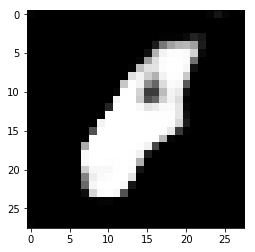

Generate another?


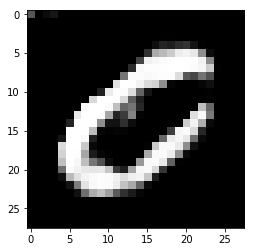

Generate another?


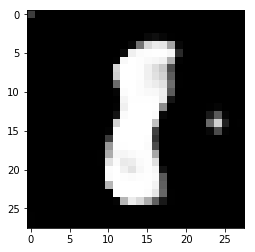

Generate another?


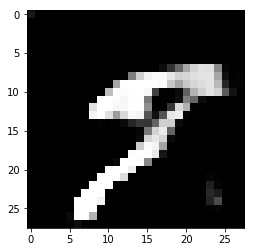

Generate another?


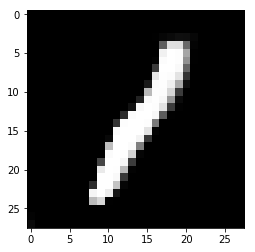

Generate another?


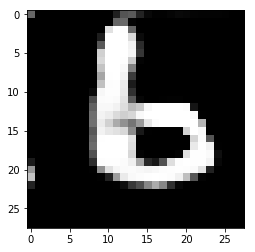

Generate another?


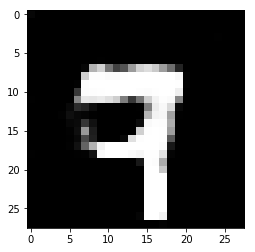

Generate another?


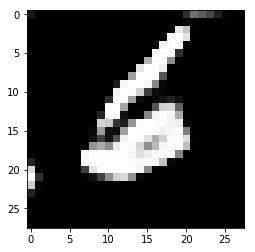

Generate another?n


In [10]:
if __name__ == '__main__':
    
    if task == 'TRAIN':
        if not os.path.exists(PATH):
            os.mkdir(PATH)
        
        elif os.path.exists(PATH):
    
            ans = input('Do you want to overwrite the current model saved at '+PATH+'?\n')
            if ans and ans[0] in ('n' or 'N'):
                PATH = input('Specify the name of the model, a new directory will be created.\n')
                os.mkdir(PATH)
            else:
                print('Overwriting existing model in '+PATH)
    if task == 'TEST':
        
        print('Testing...\n')
        
    #HCAL()
    mnist()